# 3. AutoEncoder Demo (Conv2d and ConvTranspose2d)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (29/08/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.2)
- Numpy (tested on v1.25.2)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)
- We also strongly recommend setting up CUDA on your machine! (At this point, honestly, it is almost mandatory).

### Imports

In [1]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


### Dataset and dataloaders

As seen many times before...

In [3]:
# Data Preprocessing
# - ToTensor
# - Image Normalization
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0.1307,), (0.3081,))])

In [4]:
# Train datasets/dataloaders
train_set = torchvision.datasets.MNIST(root='./data', \
                                       train = True, \
                                       download = True, \
                                       transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, \
                                           batch_size = 32, \
                                           shuffle = False)

In [5]:
# Test datasets/dataloaders
test_set = torchvision.datasets.MNIST(root = './data', \
                                      train = False, \
                                      download = True, \
                                      transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, \
                                          batch_size = 4, \
                                          shuffle = False)

### Model

Conv2d layers are used in the Encoder part this time; whereas ConvTranspose2d layers are used in the Decoder part.

Note how the parameters of the Conv2d and ConvTranspose2d layers are mirrored as before in the Linear autoencoder.

In [6]:
# Define AutoEncoder Model for MNIST
class MNIST_Autoencoder(nn.Module):

    def __init__(self, hidden_layer = 7):
        
        # Init from nn.Module
        super().__init__()
        
        # Encoder part will be a simple sequence of Conv2d+ReLU.
        self.encoder = nn.Sequential(nn.Conv2d(1, 16, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, hidden_layer))
        
        
        # Decoder part will be a simple sequence of TransposeConv2d+ReLU.
        # Finish with Sigmoid
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, hidden_layer),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU())
        

    def forward(self,x):
        
        # Forward is encoder into decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Train model

We will implement a trainer function as in Notebook 1.

In [7]:
# Initialize MNIST Autoencoder
torch.manual_seed(10)
model = MNIST_Autoencoder(hidden_layer = 7).to(device)

In [8]:
# Defining Parameters
# - MSE Loss, which will be our reconstruction loss for now
# - Adam as optimizer
# - 20 Epochs
# - 128 as batch size
num_epochs = 20
batch_size = 128
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-5)

In [9]:
# Train
outputs_list = []
loss_list = []
for epoch in range(num_epochs):
    for data in train_loader:
        
        # Send data to device
        img, _ = data
        img = Variable(img).to(device)
        
        # Forward pass
        output = model(img)
        loss = distance(output, img)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())

epoch 1/20, loss 0.1973
epoch 2/20, loss 0.1837
epoch 3/20, loss 0.1800
epoch 4/20, loss 0.1785
epoch 5/20, loss 0.1775
epoch 6/20, loss 0.1768
epoch 7/20, loss 0.1763
epoch 8/20, loss 0.1756
epoch 9/20, loss 0.1757
epoch 10/20, loss 0.1756
epoch 11/20, loss 0.1763
epoch 12/20, loss 0.1760
epoch 13/20, loss 0.1765
epoch 14/20, loss 0.1760
epoch 15/20, loss 0.1762
epoch 16/20, loss 0.1758
epoch 17/20, loss 0.1755
epoch 18/20, loss 0.1750
epoch 19/20, loss 0.1757
epoch 20/20, loss 0.1743


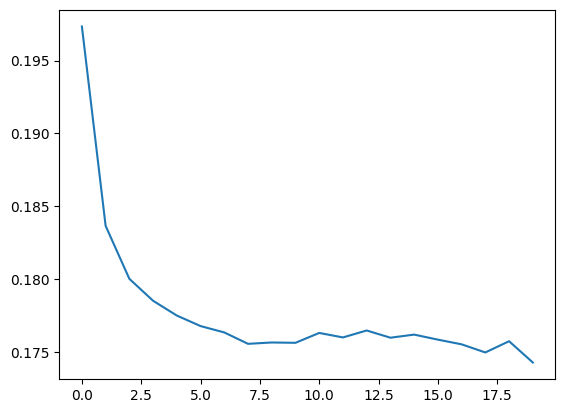

In [10]:
# Display training curves
plt.figure()
plt.plot(loss_list)
plt.show()

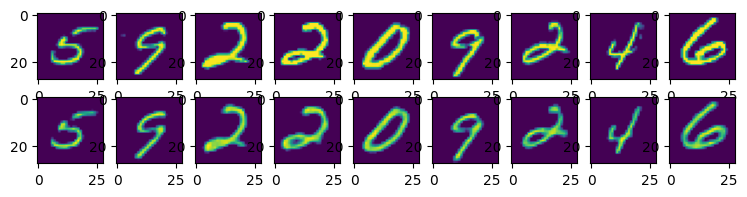

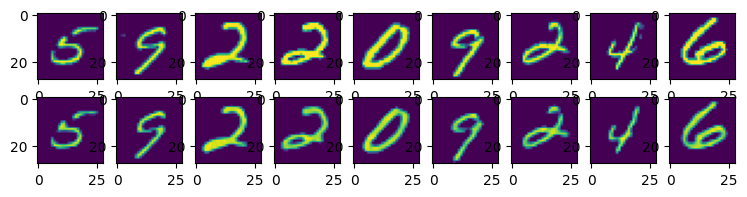

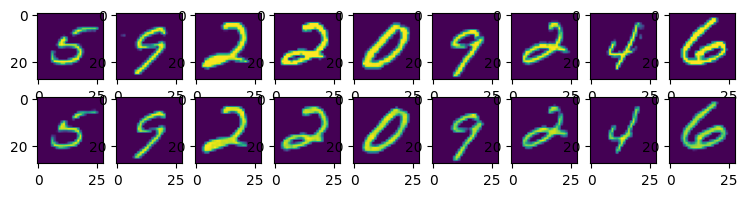

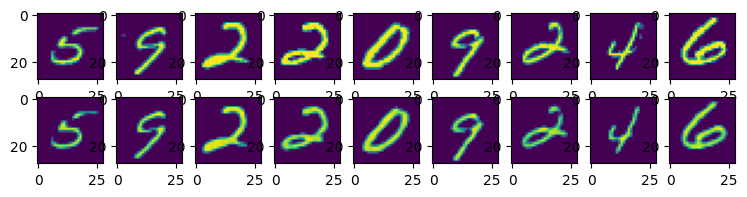

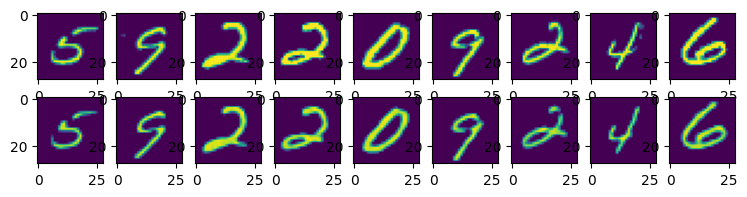

In [11]:
# Display some outputs
for k in range(0, num_epochs, 4):
    plt.figure(figsize = (9, 2))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])